In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import StandardScaler

# Carregamento dos dados

In [3]:
USERS_FILEPATH = 'data/users.dat'
MOVIES_FILEPATH = 'data/movies.dat'
RATINGS_FILEPATH = 'data/ratings.dat'

In [24]:
column_names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']
users_df = pd.read_csv(USERS_FILEPATH, sep='::', names=column_names, engine='python')
column_names = ['MovieID', 'Title', 'Genres']
movies_df = pd.read_csv(MOVIES_FILEPATH, sep='::', names=column_names, engine='python', encoding='ISO-8859-1')
column_names = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df = pd.read_csv(RATINGS_FILEPATH, sep='::', names=column_names, engine='python')
ratings_df['Timestamp'] = pd.to_datetime(ratings_df['Timestamp'], unit='s')

print(users_df.head())
print("-"*150)
print(movies_df.head())
print("-"*150)
print(ratings_df.head())

   UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455
----------------------------------------------------------------------------------------------------
   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
------------------------------------------------------------------------------------------------------------------------------------------------------
   UserID  MovieID  Rating  

# Análise exploratória

In [7]:
print(f"Quantidade de filmes: {len(movies_df.index)}")
print(f"Quantidade de usuários: {len(users_df.index)}")
print(f"Quantidade de avaliações: {len(ratings_df.index)}")

Quantidade de filmes: 3883
Quantidade de usuários: 6040
Quantidade de avaliações: 1000209


In [8]:
all_genres = movies_df['Genres'].str.split('|').explode()
distinct_genres = all_genres.unique().tolist()
distinct_genres.sort()
print(f'Gêneros de filmes: {distinct_genres}')

Gêneros de filmes: ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


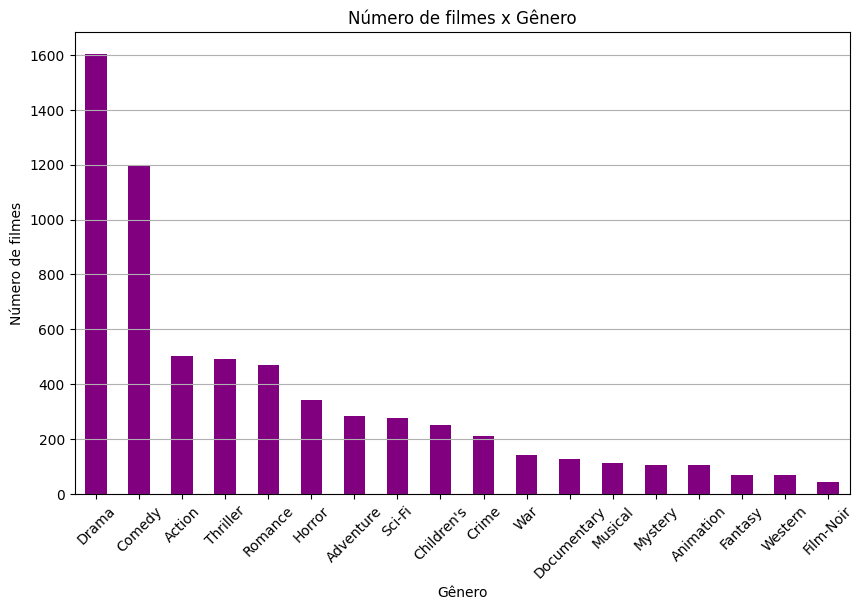

In [9]:
def plot_films_by_genre(df: pd.DataFrame):
   
    expanded_genres = df['Genres'].str.split('|').explode()
    genre_counts = expanded_genres.value_counts()
    
    plt.figure(figsize=(16, 4)) 
    genre_counts.plot(kind='bar', figsize=(10, 6), color='purple')
    plt.title('Número de filmes x Gênero')
    plt.xlabel('Gênero')
    plt.ylabel('Número de filmes')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

plot_films_by_genre(movies_df)

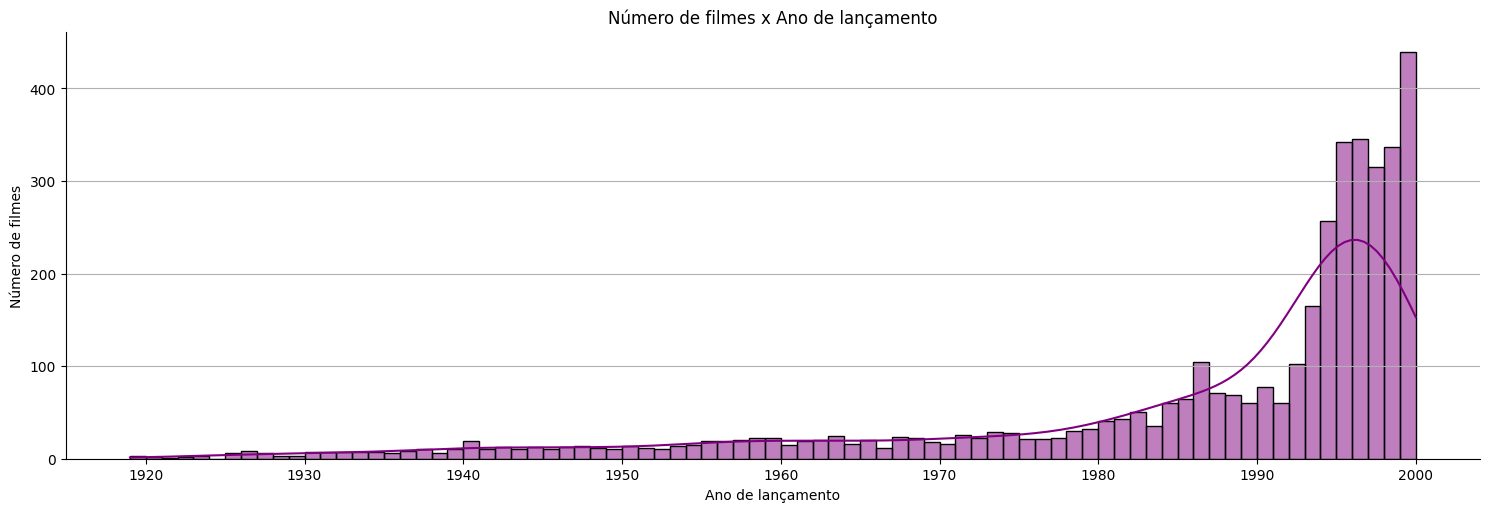

In [10]:
def plot_films_by_year(df: pd.DataFrame):  
    df['Year'] = df['Title'].str.extract(r'\((\d{4})\)').astype(int)

    sns.displot(df, x='Year', binwidth=1, aspect=3, kde=True, color='purple')
    plt.title('Número de filmes x Ano de lançamento')
    plt.xlabel('Ano de lançamento')
    plt.ylabel('Número de filmes')
    plt.grid(axis='y')
    plt.show()

plot_films_by_year(movies_df)

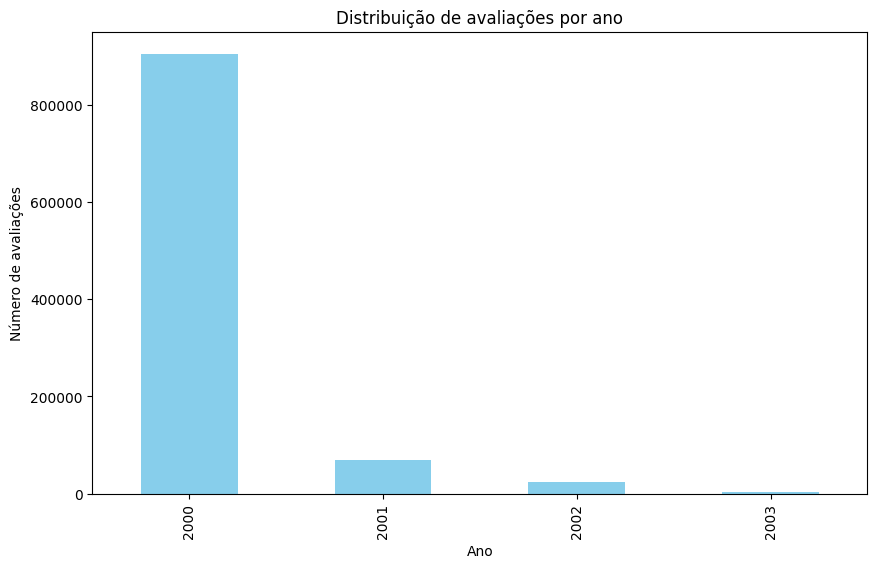

In [25]:
def plot_ratings_by_year(df: pd.DataFrame):
    df['Year'] = df['Timestamp'].dt.year

    # Group by year and count ratings
    ratings_by_year = df.groupby('Year')['Rating'].count()

    # Plot distribution of ratings by year
    ratings_by_year.plot(kind='bar', figsize=(10, 6), color='skyblue')
    plt.xlabel('Ano')
    plt.ylabel('Número de avaliações')
    plt.title('Distribuição de avaliações por ano')
    plt.show()
plot_ratings_by_year(ratings_df)

In [20]:
ratings_df.duplicated(subset=['UserID', 'MovieID']).any()

False

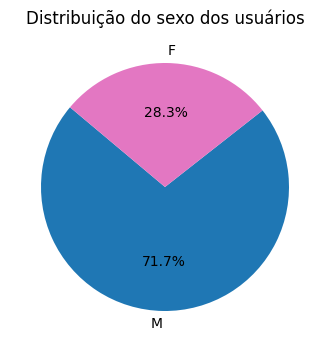

In [12]:
def plot_user_by_genre(df: pd.DataFrame):
    gender_counts = df['Gender'].value_counts()
    plt.figure(figsize=(4, 6))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140, colors=['tab:blue', 'tab:pink'])
    plt.title('Distribuição do sexo dos usuários')
    plt.show()

plot_user_by_genre(users_df)

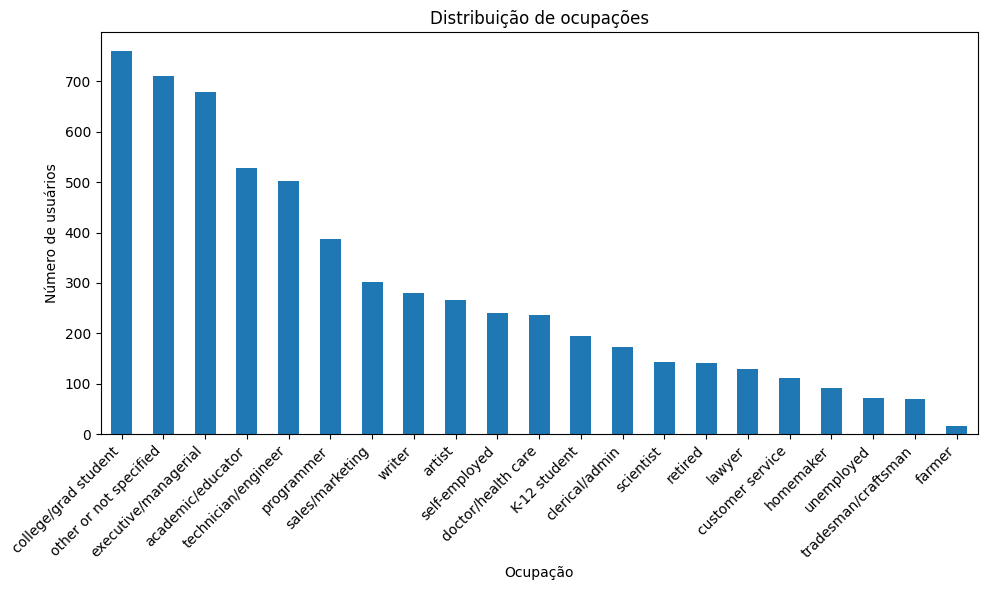

In [13]:
def plot_user_occupation_distribution(df: pd.DataFrame):
    occupation_mapping = {
        0: "other or not specified",
        1: "academic/educator",
        2: "artist",
        3: "clerical/admin",
        4: "college/grad student",
        5: "customer service",
        6: "doctor/health care",
        7: "executive/managerial",
        8: "farmer",
        9: "homemaker",
        10: "K-12 student",
        11: "lawyer",
        12: "programmer",
        13: "retired",
        14: "sales/marketing",
        15: "scientist",
        16: "self-employed",
        17: "technician/engineer",
        18: "tradesman/craftsman",
        19: "unemployed",
        20: "writer"
    }

    df['Occupation_str'] = df['Occupation'].map(occupation_mapping)

    # Count the occurrences of each occupation
    occupation_counts = df['Occupation_str'].value_counts()

    # Plotting a bar chart
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    occupation_counts.plot(kind='bar')
    plt.xlabel('Ocupação')
    plt.ylabel('Número de usuários')
    plt.title('Distribuição de ocupações')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_user_occupation_distribution(users_df)

      UserID  RatingCount
0       4169         2314
1       1680         1850
2       4277         1743
3       1941         1595
4       1181         1521
...      ...          ...
6035    5725           20
6036    3407           20
6037    1664           20
6038    4419           20
6039    3021           20

[6040 rows x 2 columns]


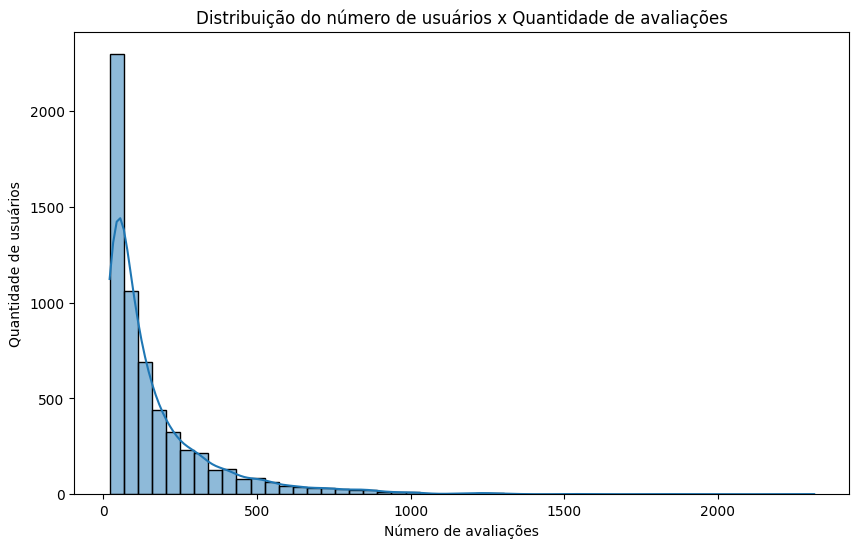

In [14]:
def plot_users_rating_amount_distribution(df: pd.DataFrame):
    # Count number of ratings per user
    ratings_per_user = df['UserID'].value_counts().reset_index()
    ratings_per_user.columns = ['UserID', 'RatingCount']
    print(ratings_per_user)
    # Plotting with Seaborn
    plt.figure(figsize=(10, 6))
    sns.histplot(ratings_per_user['RatingCount'], bins=50, kde=True)
    plt.xlabel('Número de avaliações')
    plt.ylabel('Quantidade de usuários')
    plt.title('Distribuição do número de usuários x Quantidade de avaliações')
    plt.show()
plot_users_rating_amount_distribution(ratings_df)

In [22]:

scaler = StandardScaler()
ratings_df['Rating_scaled'] = scaler.fit_transform(ratings_df[['Rating']])
ratings_df

,UserID,MovieID,Rating,Timestamp,Year,Rating_scaled
0,1,1193,5,2000-12-31 22:12:40,2000,1.269747
1,1,661,3,2000-12-31 22:35:09,2000,-0.520601
2,1,914,3,2000-12-31 22:32:48,2000,-0.520601
3,1,3408,4,2000-12-31 22:04:35,2000,0.374573
4,1,2355,5,2001-01-06 23:38:11,2001,1.269747
...,...,...,...,...,...,...
1000204,6040,1091,1,2000-04-26 02:35:41,2000,-2.310949
1000205,6040,1094,5,2000-04-25 23:21:27,2000,1.269747
1000206,6040,562,5,2000-04-25 23:19:06,2000,1.269747
1000207,6040,1096,4,2000-04-26 02:20:48,2000,0.374573
